In [1]:
import numpy as np
import subprocess
import time

ftrain = "data/landsat_train.csv"
wc_train = int(subprocess.check_output(["wc", "-l",ftrain]).split()[0])

In [2]:

def chunk_generator(fname, chunk_size=10000):
        data = []
        counter = 0

        with open(fname, 'r') as ifile:

            for line in ifile:
                if counter < chunk_size:
                    data.append([int(p) for p in line.split(",")])
                    counter += 1
                if counter == chunk_size:
                    counter = 0
                    yield data
                    data = []
                    
            # process remaining elements
            if len(data) > 0:
                yield data

In [3]:
wc_dummy=10000

sample_sz = 10000
n_subsets = 10
wc = wc_train
subsets = np.zeros([n_subsets,sample_sz],dtype=int)
for i in range(n_subsets):
    subsets[i,:] = sorted(np.random.choice(wc, sample_sz, replace=False))
landsat_data = np.zeros([sample_sz,10,n_subsets])
ix_subsets = np.full([n_subsets],-1,dtype=int)
search = np.array(subsets[:,0])

In [4]:
start = time.time()

cnt = 0
chunk_cnt = 1
chunk_sz = 500000
exit_flag=False

for chunk in chunk_generator(ftrain, chunk_sz):
    print("Processing chunk %i/%i, current counter at %i" %(chunk_cnt, wc/chunk_sz+1, cnt))
    print("Last indices set in data matrix: %s / %i" % (str(ix_subsets),sample_sz))
    print("Now searching for line: %s" % str(search))
    if exit_flag : break
    for line in chunk :
        if cnt>=wc :
            exit_flag=True
            break
        # find a line number in the stream
        found = np.argwhere(search==cnt)
        #if len(found) >0 :print("found "+str(found))
        for f in found[:,0]:
            # move in the subset array to next index
            ix_subsets[f] += 1
            # f is the subset which the data belongs to - assign to the data
            landsat_data[ix_subsets[f],:,f] = line
            # move to the new value in the subset
            if ix_subsets[f]<sample_sz-1:
                search[f] = subsets[f,ix_subsets[f]+1]
        
        cnt +=1
    chunk_cnt +=1
end = time.time()
print("finished going through %i values out of a total of %i in %s seconds " % (cnt,wc,end-start))
del subsets
del chunk

Processing chunk 1/52, current counter at 0
Last indices set in data matrix: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] / 10000
Now searching for line: [ 216   91  127  171 2199 3877 2300 5860 3371 3015]
Processing chunk 2/52, current counter at 500000
Last indices set in data matrix: [184 194 209 185 199 187 202 181 187 176] / 10000
Now searching for line: [501616 500559 500275 502289 504979 503302 500461 501378 504418 501266]
Processing chunk 3/52, current counter at 1000000
Last indices set in data matrix: [390 362 393 367 369 362 413 395 382 391] / 10000
Now searching for line: [1013858 1002164 1000025 1002363 1002797 1004930 1001338 1000815 1000017
 1001212]
Processing chunk 4/52, current counter at 1500000
Last indices set in data matrix: [585 573 593 577 550 570 584 595 591 583] / 10000
Now searching for line: [1501045 1504843 1502488 1500634 1500880 1503575 1502533 1508542 1505927
 1500961]
Processing chunk 5/52, current counter at 2000000
Last indices set in data matrix: [770 744 768 766

In [5]:
from sklearn.tree import DecisionTreeClassifier

trees = []
for sset in range(landsat_data.shape[2]):
    Xtrain, ytrain = landsat_data[:,1:,sset], landsat_data[:,0,sset]
    print("Fitting model %i..." % (sset+1))
    model = DecisionTreeClassifier(criterion='gini',
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   max_features=None)
    model.fit(Xtrain, ytrain)
    print("Model fitted!")
    trees.append(model)

Fitting model 1...
Model fitted!
Fitting model 2...
Model fitted!
Fitting model 3...
Model fitted!
Fitting model 4...
Model fitted!
Fitting model 5...
Model fitted!
Fitting model 6...
Model fitted!
Fitting model 7...
Model fitted!
Fitting model 8...
Model fitted!
Fitting model 9...
Model fitted!
Fitting model 10...
Model fitted!


In [6]:
ftest = "data/landsat_test.csv"
wc_train = int(subprocess.check_output(["wc", "-l",ftest]).split()[0])

In [12]:
wc = wc_train
ypreds = np.zeros([wc,10])
#ytest = np.zeros([wc,1])
chunk_sz = 500000
chunk_cnt=0
cnt=0
start = time.time()
for chunk in chunk_generator(ftest, chunk_sz):
    print("Processing chunk %i/%i, current counter at %i" %(chunk_cnt+1, wc/chunk_sz+1, cnt))
    start_ix=cnt
    Xtest=np.zeros([chunk_sz,9])
    for line in chunk :
        Xtest[cnt-chunk_cnt*chunk_sz,:] = line
        cnt+=1
    end_ix=cnt
    print "Predicting ..."
    for t_i in range(len(trees)):
        ypreds[start_ix:end_ix,t_i]=trees[t_i].predict(Xtest)
    chunk_cnt +=1
end = time.time()
print("finished going through %i values out of a total of %i in %s seconds " % (cnt,wc,end-start))
del chunk

Processing chunk 1/19, current counter at 0
Predicting ...
Processing chunk 2/19, current counter at 500000
Predicting ...
Processing chunk 3/19, current counter at 1000000
Predicting ...
Processing chunk 4/19, current counter at 1500000
Predicting ...
Processing chunk 5/19, current counter at 2000000
Predicting ...
Processing chunk 6/19, current counter at 2500000
Predicting ...
Processing chunk 7/19, current counter at 3000000
Predicting ...
Processing chunk 8/19, current counter at 3500000
Predicting ...
Processing chunk 9/19, current counter at 4000000
Predicting ...
Processing chunk 10/19, current counter at 4500000
Predicting ...
Processing chunk 11/19, current counter at 5000000
Predicting ...
Processing chunk 12/19, current counter at 5500000
Predicting ...
Processing chunk 13/19, current counter at 6000000
Predicting ...
Processing chunk 14/19, current counter at 6500000
Predicting ...
Processing chunk 15/19, current counter at 7000000
Predicting ...
Processing chunk 16/19, cu

In [13]:
majority_ypreds = np.zeros([wc,1])
for i in range(ypreds.shape[0]):
    ycounts = np.bincount(ypreds[i,:].astype(int))
    majority_ypreds[i] = np.argmax(ycounts)

In [14]:
from matplotlib import pyplot as plt
# function to plot the predicted classes
def plot_image(preds):
    alpha = range(2,8,1)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(preds.reshape(3000,3000), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

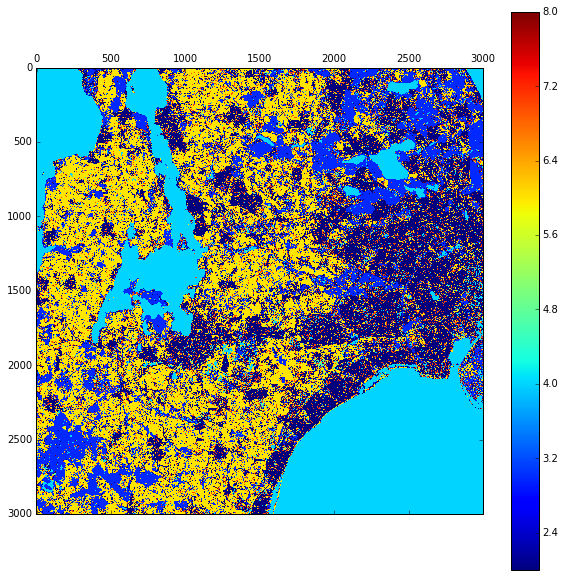

In [15]:
plot_image(majority_ypreds)

In [16]:
freq=np.bincount(majority_ypreds[:,0].astype(int))
print("Frequency of appearance: %s" % str(freq))
print("Most frequent : %s" % str(np.argmax(freq)))

Frequency of appearance: [      0       0 2212058 1353200 2094475   22530 2690463  536110   91164]
Most frequent : 6
